# Home Credit Default Risk

Kaggle Question:

https://www.kaggle.com/c/home-credit-default-risk/data


The pipeline of this work:

1. Load training and testing data

2. check labeled data (ground truth)

3. check missing values

4. Encode Categorical Data, two ways:

   - from sklearn.preprocessing import LabelEncoder
     LabelEncoder

   - one-hot: pd.get_dummie, then align train and test, by df_train, df_test = df_train.align(df_test, join = 'inner', axis = 1)


5. Check anomalies

6. Correlation, analyze first several features

7. Baseline Model:

   - Logistic Regression

   - Random Forest

   - XGBoost
   
   
Reference:

https://www.kaggle.com/willkoehrsen/start-here-a-gentle-introduction

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import LabelEncoder
import os

import warnings
warnings.filterwarnings('ignore')

In [2]:
ls -l data

total 5242728
-rwxr-xr-x@ 1 dongzhang  staff      37383 Dec 11 02:58 HomeCredit_columns_description.csv*
-rwxr-xr-x@ 1 dongzhang  staff  392703158 Dec 11 02:58 POS_CASH_balance.csv*
-rwxr-xr-x@ 1 dongzhang  staff   26567651 Dec 11 02:58 application_test.csv*
-rwxr-xr-x@ 1 dongzhang  staff  166133370 Dec 11 02:59 application_train.csv*
-rwxr-xr-x@ 1 dongzhang  staff  170016717 Dec 11 02:59 bureau.csv*
-rwxr-xr-x@ 1 dongzhang  staff  375592889 Dec 11 02:59 bureau_balance.csv*
-rwxr-xr-x@ 1 dongzhang  staff  424582605 Dec 11 03:00 credit_card_balance.csv*
-rwxr-xr-x@ 1 dongzhang  staff  723118349 Dec 11 03:00 installments_payments.csv*
-rwxr-xr-x@ 1 dongzhang  staff  404973293 Dec 11 03:02 previous_application.csv*
-rwxr-xr-x@ 1 dongzhang  staff     536202 Dec 11 03:02 sample_submission.csv*


## Read All Data

In [3]:
df_train = pd.read_csv('data/application_train.csv')

In [4]:
df_train.shape

(307511, 122)

In [5]:
df_train.head(10)

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,...,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,100002,1,Cash loans,M,N,Y,0,202500.0,406597.5,24700.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0
1,100003,0,Cash loans,F,N,N,0,270000.0,1293502.5,35698.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
2,100004,0,Revolving loans,M,Y,Y,0,67500.0,135000.0,6750.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
3,100006,0,Cash loans,F,N,Y,0,135000.0,312682.5,29686.5,...,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
4,100007,0,Cash loans,M,N,Y,0,121500.0,513000.0,21865.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
5,100008,0,Cash loans,M,N,Y,0,99000.0,490495.5,27517.5,...,0,0,0,0,0.0,0.0,0.0,0.0,1.0,1.0
6,100009,0,Cash loans,F,Y,Y,1,171000.0,1560726.0,41301.0,...,0,0,0,0,0.0,0.0,0.0,1.0,1.0,2.0
7,100010,0,Cash loans,M,Y,Y,0,360000.0,1530000.0,42075.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
8,100011,0,Cash loans,F,N,Y,0,112500.0,1019610.0,33826.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0
9,100012,0,Revolving loans,M,N,Y,0,135000.0,405000.0,20250.0,...,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN


In [6]:
df_test = pd.read_csv('data/application_test.csv')
df_test.shape

(48744, 121)

In [7]:
df_test.head()

,SK_ID_CURR,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,...,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,100001,Cash loans,F,N,Y,0,135000.0,568800.0,20560.5,450000.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
1,100005,Cash loans,M,N,Y,0,99000.0,222768.0,17370.0,180000.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,3.0
2,100013,Cash loans,M,Y,Y,0,202500.0,663264.0,69777.0,630000.0,...,0,0,0,0,0.0,0.0,0.0,0.0,1.0,4.0
3,100028,Cash loans,F,N,Y,2,315000.0,1575000.0,49018.5,1575000.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,3.0
4,100038,Cash loans,M,Y,N,1,180000.0,625500.0,32067.0,625500.0,...,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN


In [8]:
df_bureau = pd.read_csv('data/bureau.csv')
df_bureau.shape

(1716428, 17)

In [9]:
df_bureau.head()

,SK_ID_CURR,SK_ID_BUREAU,CREDIT_ACTIVE,CREDIT_CURRENCY,DAYS_CREDIT,CREDIT_DAY_OVERDUE,DAYS_CREDIT_ENDDATE,DAYS_ENDDATE_FACT,AMT_CREDIT_MAX_OVERDUE,CNT_CREDIT_PROLONG,AMT_CREDIT_SUM,AMT_CREDIT_SUM_DEBT,AMT_CREDIT_SUM_LIMIT,AMT_CREDIT_SUM_OVERDUE,CREDIT_TYPE,DAYS_CREDIT_UPDATE,AMT_ANNUITY
0,215354,5714462,Closed,currency 1,-497,0,-153.0,-153.0,NaN,0,91323.0,0.0,NaN,0.0,Consumer credit,-131,NaN
1,215354,5714463,Active,currency 1,-208,0,1075.0,NaN,NaN,0,225000.0,171342.0,NaN,0.0,Credit card,-20,NaN
2,215354,5714464,Active,currency 1,-203,0,528.0,NaN,NaN,0,464323.5,NaN,NaN,0.0,Consumer credit,-16,NaN
3,215354,5714465,Active,currency 1,-203,0,NaN,NaN,NaN,0,90000.0,NaN,NaN,0.0,Credit card,-16,NaN
4,215354,5714466,Active,currency 1,-629,0,1197.0,NaN,77674.5,0,2700000.0,NaN,NaN,0.0,Consumer credit,-21,NaN


In [10]:
df_bb = pd.read_csv('data/bureau_balance.csv')
df_bb.shape

(27299925, 3)

In [11]:
df_bb.head()

,SK_ID_BUREAU,MONTHS_BALANCE,STATUS
0,5715448,0,C
1,5715448,-1,C
2,5715448,-2,C
3,5715448,-3,C
4,5715448,-4,C


In [12]:
df_prev = pd.read_csv('data/previous_application.csv')
df_prev.shape

(1670214, 37)

In [13]:
df_prev.head()

,SK_ID_PREV,SK_ID_CURR,NAME_CONTRACT_TYPE,AMT_ANNUITY,AMT_APPLICATION,AMT_CREDIT,AMT_DOWN_PAYMENT,AMT_GOODS_PRICE,WEEKDAY_APPR_PROCESS_START,HOUR_APPR_PROCESS_START,...,NAME_SELLER_INDUSTRY,CNT_PAYMENT,NAME_YIELD_GROUP,PRODUCT_COMBINATION,DAYS_FIRST_DRAWING,DAYS_FIRST_DUE,DAYS_LAST_DUE_1ST_VERSION,DAYS_LAST_DUE,DAYS_TERMINATION,NFLAG_INSURED_ON_APPROVAL
0,2030495,271877,Consumer loans,1730.430,17145.0,17145.0,0.0,17145.0,SATURDAY,15,...,Connectivity,12.0,middle,POS mobile with interest,365243.0,-42.0,300.0,-42.0,-37.0,0.0
1,2802425,108129,Cash loans,25188.615,607500.0,679671.0,NaN,607500.0,THURSDAY,11,...,XNA,36.0,low_action,Cash X-Sell: low,365243.0,-134.0,916.0,365243.0,365243.0,1.0
2,2523466,122040,Cash loans,15060.735,112500.0,136444.5,NaN,112500.0,TUESDAY,11,...,XNA,12.0,high,Cash X-Sell: high,365243.0,-271.0,59.0,365243.0,365243.0,1.0
3,2819243,176158,Cash loans,47041.335,450000.0,470790.0,NaN,450000.0,MONDAY,7,...,XNA,12.0,middle,Cash X-Sell: middle,365243.0,-482.0,-152.0,-182.0,-177.0,1.0
4,1784265,202054,Cash loans,31924.395,337500.0,404055.0,NaN,337500.0,THURSDAY,9,...,XNA,24.0,high,Cash Street: high,NaN,NaN,NaN,NaN,NaN,NaN


In [14]:
df_pc = pd.read_csv('data/POS_CASH_balance.csv')
df_pc.shape

(10001358, 8)

In [15]:
df_pc.head(20)

,SK_ID_PREV,SK_ID_CURR,MONTHS_BALANCE,CNT_INSTALMENT,CNT_INSTALMENT_FUTURE,NAME_CONTRACT_STATUS,SK_DPD,SK_DPD_DEF
0,1803195,182943,-31,48.0,45.0,Active,0,0
1,1715348,367990,-33,36.0,35.0,Active,0,0
2,1784872,397406,-32,12.0,9.0,Active,0,0
3,1903291,269225,-35,48.0,42.0,Active,0,0
4,2341044,334279,-35,36.0,35.0,Active,0,0
5,2207092,342166,-32,12.0,12.0,Active,0,0
6,1110516,204376,-38,48.0,43.0,Active,0,0
7,1387235,153211,-35,36.0,36.0,Active,0,0
8,1220500,112740,-31,12.0,12.0,Active,0,0
9,2371489,274851,-32,24.0,16.0,Active,0,0


In [16]:
df_install = pd.read_csv('data/installments_payments.csv')
df_install.shape

(13605401, 8)

In [17]:
df_install.head()

,SK_ID_PREV,SK_ID_CURR,NUM_INSTALMENT_VERSION,NUM_INSTALMENT_NUMBER,DAYS_INSTALMENT,DAYS_ENTRY_PAYMENT,AMT_INSTALMENT,AMT_PAYMENT
0,1054186,161674,1.0,6,-1180.0,-1187.0,6948.360,6948.360
1,1330831,151639,0.0,34,-2156.0,-2156.0,1716.525,1716.525
2,2085231,193053,2.0,1,-63.0,-63.0,25425.000,25425.000
3,2452527,199697,1.0,3,-2418.0,-2426.0,24350.130,24350.130
4,2714724,167756,1.0,2,-1383.0,-1366.0,2165.040,2160.585


In [18]:
df_ccb = pd.read_csv('data/credit_card_balance.csv')

In [19]:
df_ccb.shape

(3840312, 23)

In [20]:
df_ccb.head()

,SK_ID_PREV,SK_ID_CURR,MONTHS_BALANCE,AMT_BALANCE,AMT_CREDIT_LIMIT_ACTUAL,AMT_DRAWINGS_ATM_CURRENT,AMT_DRAWINGS_CURRENT,AMT_DRAWINGS_OTHER_CURRENT,AMT_DRAWINGS_POS_CURRENT,AMT_INST_MIN_REGULARITY,...,AMT_RECIVABLE,AMT_TOTAL_RECEIVABLE,CNT_DRAWINGS_ATM_CURRENT,CNT_DRAWINGS_CURRENT,CNT_DRAWINGS_OTHER_CURRENT,CNT_DRAWINGS_POS_CURRENT,CNT_INSTALMENT_MATURE_CUM,NAME_CONTRACT_STATUS,SK_DPD,SK_DPD_DEF
0,2562384,378907,-6,56.970,135000,0.0,877.5,0.0,877.5,1700.325,...,0.000,0.000,0.0,1,0.0,1.0,35.0,Active,0,0
1,2582071,363914,-1,63975.555,45000,2250.0,2250.0,0.0,0.0,2250.000,...,64875.555,64875.555,1.0,1,0.0,0.0,69.0,Active,0,0
2,1740877,371185,-7,31815.225,450000,0.0,0.0,0.0,0.0,2250.000,...,31460.085,31460.085,0.0,0,0.0,0.0,30.0,Active,0,0
3,1389973,337855,-4,236572.110,225000,2250.0,2250.0,0.0,0.0,11795.760,...,233048.970,233048.970,1.0,1,0.0,0.0,10.0,Active,0,0
4,1891521,126868,-1,453919.455,450000,0.0,11547.0,0.0,11547.0,22924.890,...,453919.455,453919.455,0.0,1,0.0,1.0,101.0,Active,0,0


## Train Data Analysis

In [21]:
df_train.dtypes

SK_ID_CURR                      int64
TARGET                          int64
NAME_CONTRACT_TYPE             object
CODE_GENDER                    object
FLAG_OWN_CAR                   object
FLAG_OWN_REALTY                object
CNT_CHILDREN                    int64
AMT_INCOME_TOTAL              float64
AMT_CREDIT                    float64
AMT_ANNUITY                   float64
AMT_GOODS_PRICE               float64
NAME_TYPE_SUITE                object
NAME_INCOME_TYPE               object
NAME_EDUCATION_TYPE            object
NAME_FAMILY_STATUS             object
NAME_HOUSING_TYPE              object
REGION_POPULATION_RELATIVE    float64
DAYS_BIRTH                      int64
DAYS_EMPLOYED                   int64
DAYS_REGISTRATION             float64
DAYS_ID_PUBLISH                 int64
OWN_CAR_AGE                   float64
FLAG_MOBIL                      int64
FLAG_EMP_PHONE                  int64
FLAG_WORK_PHONE                 int64
FLAG_CONT_MOBILE                int64
FLAG_PHONE  

In [22]:
df_train.isnull().sum()

SK_ID_CURR                         0
TARGET                             0
NAME_CONTRACT_TYPE                 0
CODE_GENDER                        0
FLAG_OWN_CAR                       0
FLAG_OWN_REALTY                    0
CNT_CHILDREN                       0
AMT_INCOME_TOTAL                   0
AMT_CREDIT                         0
AMT_ANNUITY                       12
AMT_GOODS_PRICE                  278
NAME_TYPE_SUITE                 1292
NAME_INCOME_TYPE                   0
NAME_EDUCATION_TYPE                0
NAME_FAMILY_STATUS                 0
NAME_HOUSING_TYPE                  0
REGION_POPULATION_RELATIVE         0
DAYS_BIRTH                         0
DAYS_EMPLOYED                      0
DAYS_REGISTRATION                  0
DAYS_ID_PUBLISH                    0
OWN_CAR_AGE                   202929
FLAG_MOBIL                         0
FLAG_EMP_PHONE                     0
FLAG_WORK_PHONE                    0
FLAG_CONT_MOBILE                   0
FLAG_PHONE                         0
F

In [23]:
df_train.TARGET.value_counts()

0    282686
1     24825
Name: TARGET, dtype: int64

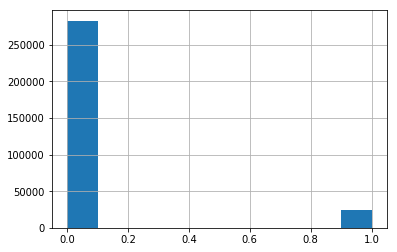

In [24]:
df_train.TARGET.hist()

In [25]:
def missing_values_table(df):
        # Total missing values
        mis_val = df.isnull().sum()
        
        # Percentage of missing values
        mis_val_percent = 100 * df.isnull().sum() / len(df)
        
        # Make a table with the results
        mis_val_table = pd.concat([mis_val, mis_val_percent], axis=1)
        
        mis_val_table = mis_val_table.rename(columns = {0: 'Missing Value Counts', 1: 'Percentage'})
        
        mis_val_table = mis_val_table[mis_val_table.Percentage != 0]\
        .sort_values('Percentage', ascending=False).round(1)
        
        return mis_val_table

In [26]:
missing_values_table(df_train)

,Missing Value Counts,Percentage
COMMONAREA_MEDI,214865,69.9
COMMONAREA_AVG,214865,69.9
COMMONAREA_MODE,214865,69.9
NONLIVINGAPARTMENTS_MEDI,213514,69.4
NONLIVINGAPARTMENTS_MODE,213514,69.4
NONLIVINGAPARTMENTS_AVG,213514,69.4
FONDKAPREMONT_MODE,210295,68.4
LIVINGAPARTMENTS_MODE,210199,68.4
LIVINGAPARTMENTS_MEDI,210199,68.4
LIVINGAPARTMENTS_AVG,210199,68.4


In [27]:
df_train.dtypes.value_counts()

float64    65
int64      41
object     16
dtype: int64

In [28]:
# Select objects

df_train.select_dtypes('object').columns

Index(['NAME_CONTRACT_TYPE', 'CODE_GENDER', 'FLAG_OWN_CAR', 'FLAG_OWN_REALTY',
       'NAME_TYPE_SUITE', 'NAME_INCOME_TYPE', 'NAME_EDUCATION_TYPE',
       'NAME_FAMILY_STATUS', 'NAME_HOUSING_TYPE', 'OCCUPATION_TYPE',
       'WEEKDAY_APPR_PROCESS_START', 'ORGANIZATION_TYPE', 'FONDKAPREMONT_MODE',
       'HOUSETYPE_MODE', 'WALLSMATERIAL_MODE', 'EMERGENCYSTATE_MODE'],
      dtype='object')

In [29]:
df_train.select_dtypes('object').apply(pd.Series.nunique, axis = 0)

NAME_CONTRACT_TYPE             2
CODE_GENDER                    3
FLAG_OWN_CAR                   2
FLAG_OWN_REALTY                2
NAME_TYPE_SUITE                7
NAME_INCOME_TYPE               8
NAME_EDUCATION_TYPE            5
NAME_FAMILY_STATUS             6
NAME_HOUSING_TYPE              6
OCCUPATION_TYPE               18
WEEKDAY_APPR_PROCESS_START     7
ORGANIZATION_TYPE             58
FONDKAPREMONT_MODE             4
HOUSETYPE_MODE                 3
WALLSMATERIAL_MODE             7
EMERGENCYSTATE_MODE            2
dtype: int64

In [30]:
# Save object fields

object_list = list(df_train.select_dtypes('object').columns)

In [31]:
df_train[object_list].isnull().sum()

NAME_CONTRACT_TYPE                 0
CODE_GENDER                        0
FLAG_OWN_CAR                       0
FLAG_OWN_REALTY                    0
NAME_TYPE_SUITE                 1292
NAME_INCOME_TYPE                   0
NAME_EDUCATION_TYPE                0
NAME_FAMILY_STATUS                 0
NAME_HOUSING_TYPE                  0
OCCUPATION_TYPE                96391
WEEKDAY_APPR_PROCESS_START         0
ORGANIZATION_TYPE                  0
FONDKAPREMONT_MODE            210295
HOUSETYPE_MODE                154297
WALLSMATERIAL_MODE            156341
EMERGENCYSTATE_MODE           145755
dtype: int64

### Encode Categorical Data

In [32]:
Label = LabelEncoder()

for cate in object_list:
    print(cate,len(df_train[cate].unique()))

NAME_CONTRACT_TYPE 2
CODE_GENDER 3
FLAG_OWN_CAR 2
FLAG_OWN_REALTY 2
NAME_TYPE_SUITE 8
NAME_INCOME_TYPE 8
NAME_EDUCATION_TYPE 5
NAME_FAMILY_STATUS 6
NAME_HOUSING_TYPE 6
OCCUPATION_TYPE 19
WEEKDAY_APPR_PROCESS_START 7
ORGANIZATION_TYPE 58
FONDKAPREMONT_MODE 5
HOUSETYPE_MODE 4
WALLSMATERIAL_MODE 8
EMERGENCYSTATE_MODE 3


In [33]:
#Label.fit(df_train['NAME_CONTRACT_TYPE'])
#Label.transform(df_train['NAME_CONTRACT_TYPE'])

In [34]:
#df_train['NAME_CONTRACT_TYPE'].head()

In [35]:
Label = LabelEncoder()

for cate in object_list:
    if len(df_train[cate].unique())<=2:
        Label.fit(df_train[cate])
        #print(cate, Label.transform(df_train[cate]))
        #print(cate, Label.transform(df_test[cate]))
        df_train[cate] = Label.transform(df_train[cate])
        df_test[cate] = Label.transform(df_test[cate])

In [36]:
cate,df_train[cate].unique()

('EMERGENCYSTATE_MODE', array(['No', nan, 'Yes'], dtype=object))

In [37]:
# One-hot-encoder

df_train = pd.get_dummies(df_train)
df_test = pd.get_dummies(df_test)

In [38]:
df_train.columns

Index(['SK_ID_CURR', 'TARGET', 'NAME_CONTRACT_TYPE', 'FLAG_OWN_CAR',
       'FLAG_OWN_REALTY', 'CNT_CHILDREN', 'AMT_INCOME_TOTAL', 'AMT_CREDIT',
       'AMT_ANNUITY', 'AMT_GOODS_PRICE',
       ...
       'HOUSETYPE_MODE_terraced house', 'WALLSMATERIAL_MODE_Block',
       'WALLSMATERIAL_MODE_Mixed', 'WALLSMATERIAL_MODE_Monolithic',
       'WALLSMATERIAL_MODE_Others', 'WALLSMATERIAL_MODE_Panel',
       'WALLSMATERIAL_MODE_Stone, brick', 'WALLSMATERIAL_MODE_Wooden',
       'EMERGENCYSTATE_MODE_No', 'EMERGENCYSTATE_MODE_Yes'],
      dtype='object', length=243)

In [39]:
df_train.shape

(307511, 243)

In [40]:
df_test.shape

(48744, 239)

## Aligning Training and Testing Data

In [41]:
train_labels = df_train['TARGET']

# Align the training and testing data, keep only columns present in both dataframes
df_train, df_test = df_train.align(df_test, join = 'inner', axis = 1)

# Add the target back in
df_train['TARGET'] = train_labels

print('Training Features shape: ', df_train.shape)
print('Testing Features shape: ', df_test.shape)

Training Features shape:  (307511, 240)
Testing Features shape:  (48744, 239)


## Anomalies

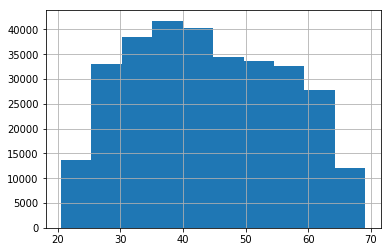

In [42]:
# Birth time looks right

(df_train['DAYS_BIRTH']/(-365)).hist()

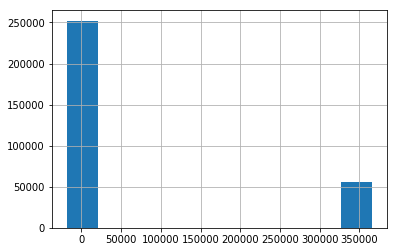

In [43]:
df_train['DAYS_EMPLOYED'].hist()

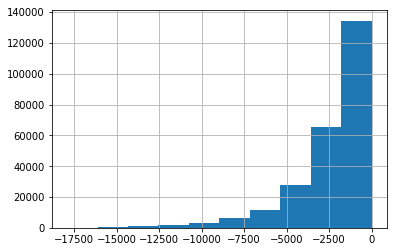

In [44]:
df_train.DAYS_EMPLOYED[df_train['DAYS_EMPLOYED']< 100000].hist()

In [45]:
df_train.DAYS_EMPLOYED[df_train['DAYS_EMPLOYED'] > 100000] = np.nan

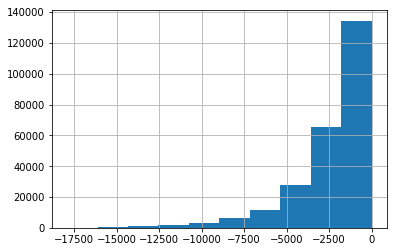

In [46]:
df_train.DAYS_EMPLOYED.hist()

## Correlation

In [47]:
correlations = df_train.corr()['TARGET'].sort_values()

In [48]:
# Most Positive Correlations:

correlations.tail(15)

OCCUPATION_TYPE_Laborers                             0.043019
FLAG_DOCUMENT_3                                      0.044346
REG_CITY_NOT_LIVE_CITY                               0.044395
FLAG_EMP_PHONE                                       0.045982
NAME_EDUCATION_TYPE_Secondary / secondary special    0.049824
REG_CITY_NOT_WORK_CITY                               0.050994
DAYS_ID_PUBLISH                                      0.051457
CODE_GENDER_M                                        0.054713
DAYS_LAST_PHONE_CHANGE                               0.055218
NAME_INCOME_TYPE_Working                             0.057481
REGION_RATING_CLIENT                                 0.058899
REGION_RATING_CLIENT_W_CITY                          0.060893
DAYS_EMPLOYED                                        0.074958
DAYS_BIRTH                                           0.078239
TARGET                                               1.000000
Name: TARGET, dtype: float64

In [49]:
#Most Negative Correlations

correlations.head(15)

EXT_SOURCE_3                           -0.178919
EXT_SOURCE_2                           -0.160472
EXT_SOURCE_1                           -0.155317
NAME_EDUCATION_TYPE_Higher education   -0.056593
CODE_GENDER_F                          -0.054704
NAME_INCOME_TYPE_Pensioner             -0.046209
ORGANIZATION_TYPE_XNA                  -0.045987
FLOORSMAX_AVG                          -0.044003
FLOORSMAX_MEDI                         -0.043768
FLOORSMAX_MODE                         -0.043226
EMERGENCYSTATE_MODE_No                 -0.042201
HOUSETYPE_MODE_block of flats          -0.040594
AMT_GOODS_PRICE                        -0.039645
REGION_POPULATION_RELATIVE             -0.037227
ELEVATORS_AVG                          -0.034199
Name: TARGET, dtype: float64

In [50]:
df_train['DAYS_BIRTH'] = abs(df_train['DAYS_BIRTH'])
df_train['DAYS_BIRTH'].corr(df_train['TARGET'])

-0.07823930830982694

Text(0, 0.5, 'Count')

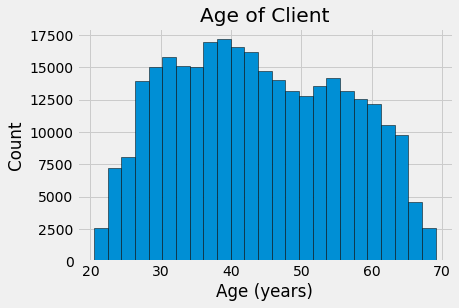

In [51]:
# Days Birth Visualization

plt.style.use('fivethirtyeight')

# Plot the distribution of ages in years
plt.hist(df_train['DAYS_BIRTH'] / 365, edgecolor = 'k', bins = 25)
plt.title('Age of Client')
plt.xlabel('Age (years)')
plt.ylabel('Count')

Text(0.5, 1.0, 'Distribution of Ages')

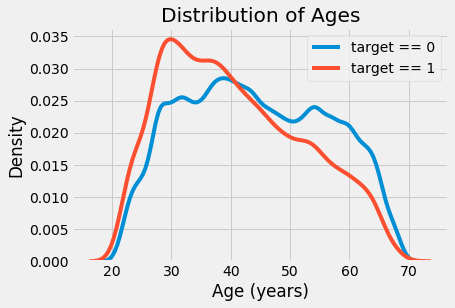

In [52]:
plt.figure(figsize = (6, 4))

# KDE plot of loans that were repaid on time
sns.kdeplot(df_train.loc[df_train['TARGET'] == 0, 'DAYS_BIRTH'] / 365, label = 'target == 0')

# KDE plot of loans which were not repaid on time
sns.kdeplot(df_train.loc[df_train['TARGET'] == 1, 'DAYS_BIRTH'] / 365, label = 'target == 1')

# Labeling of plot
plt.xlabel('Age (years)')
plt.ylabel('Density')
plt.title('Distribution of Ages')

Repay is correlated with Ages. More analysis:

In [53]:
# Bin Ages

bins_number = np.linspace(20, 70, num = 11)
bins_number

array([20., 25., 30., 35., 40., 45., 50., 55., 60., 65., 70.])

In [55]:
bins_number

array([20., 25., 30., 35., 40., 45., 50., 55., 60., 65., 70.])

In [56]:
bins = pd.cut(df_train.DAYS_BIRTH/365,bins_number)
bins.head()

0    (25.0, 30.0]
1    (45.0, 50.0]
2    (50.0, 55.0]
3    (50.0, 55.0]
4    (50.0, 55.0]
Name: DAYS_BIRTH, dtype: category
Categories (10, interval[float64]): [(20.0, 25.0] < (25.0, 30.0] < (30.0, 35.0] < (35.0, 40.0] ... (50.0, 55.0] < (55.0, 60.0] < (60.0, 65.0] < (65.0, 70.0]]

In [57]:
df_ages = df_train.groupby(bins)['TARGET'].mean().reset_index()
df_ages

,DAYS_BIRTH,TARGET
0,"(20.0, 25.0]",0.123036
1,"(25.0, 30.0]",0.111436
2,"(30.0, 35.0]",0.102814
3,"(35.0, 40.0]",0.089414
4,"(40.0, 45.0]",0.078491
5,"(45.0, 50.0]",0.074171
6,"(50.0, 55.0]",0.066968
7,"(55.0, 60.0]",0.055314
8,"(60.0, 65.0]",0.052737
9,"(65.0, 70.0]",0.037270


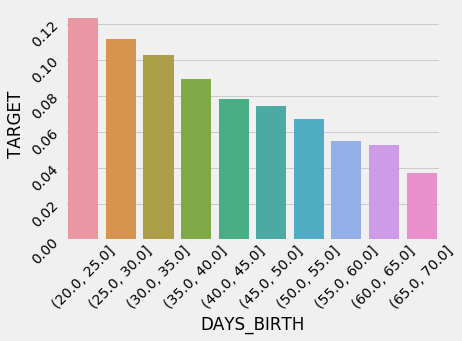

In [58]:
sns.barplot(x=df_ages.DAYS_BIRTH, y=df_ages.TARGET)
plt.tick_params(labelrotation=45)

Text(0.5, 1.0, 'Failure to Repay by Age Group')

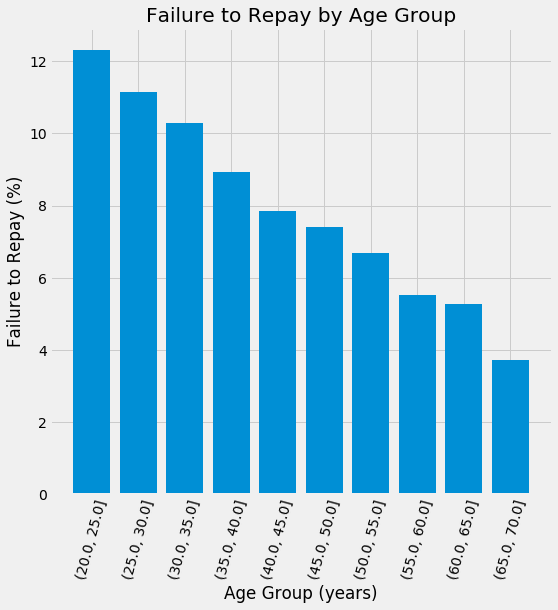

In [59]:
# Aonother way to plot

plt.figure(figsize = (8, 8))

# Graph the age bins and the average of the target as a bar plot
plt.bar(df_ages.DAYS_BIRTH.astype(str), 100 * df_ages['TARGET'])

# Plot labeling
plt.xticks(rotation = 75)
plt.xlabel('Age Group (years)')
plt.ylabel('Failure to Repay (%)')
plt.title('Failure to Repay by Age Group')

### Exterior Sources

In [60]:
df_train.EXT_SOURCE_1.isnull().sum()/df_train.shape[0]

0.5638107254699832

In [61]:
df_extra = df_train[['TARGET', 'EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3', 'DAYS_BIRTH']]
df_extra

,TARGET,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,DAYS_BIRTH
0,1,0.083037,0.262949,0.139376,9461
1,0,0.311267,0.622246,NaN,16765
2,0,NaN,0.555912,0.729567,19046
3,0,NaN,0.650442,NaN,19005
4,0,NaN,0.322738,NaN,19932
5,0,NaN,0.354225,0.621226,16941
6,0,0.774761,0.724000,0.492060,13778
7,0,NaN,0.714279,0.540654,18850
8,0,0.587334,0.205747,0.751724,20099
9,0,NaN,0.746644,NaN,14469


In [62]:
df_extra.isnull().sum()

TARGET               0
EXT_SOURCE_1    173378
EXT_SOURCE_2       660
EXT_SOURCE_3     60965
DAYS_BIRTH           0
dtype: int64

Text(0.5, 1.0, 'Correlation Heatmap')

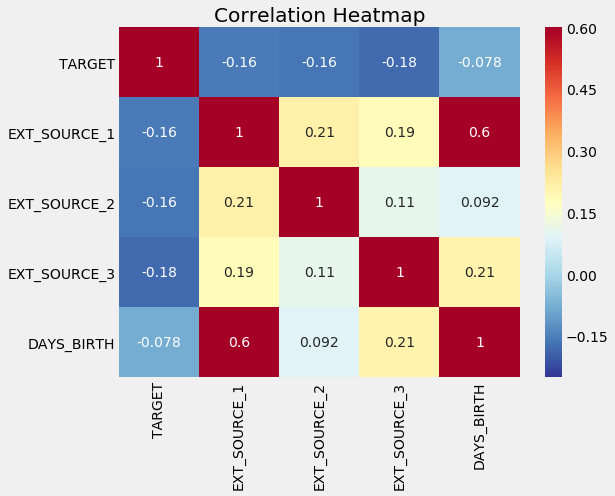

In [63]:
plt.figure(figsize = (8, 6))

# Heatmap of correlations
sns.heatmap(df_extra.corr(), cmap = plt.cm.RdYlBu_r, vmin = -0.25, annot = True, vmax = 0.6)
plt.title('Correlation Heatmap')

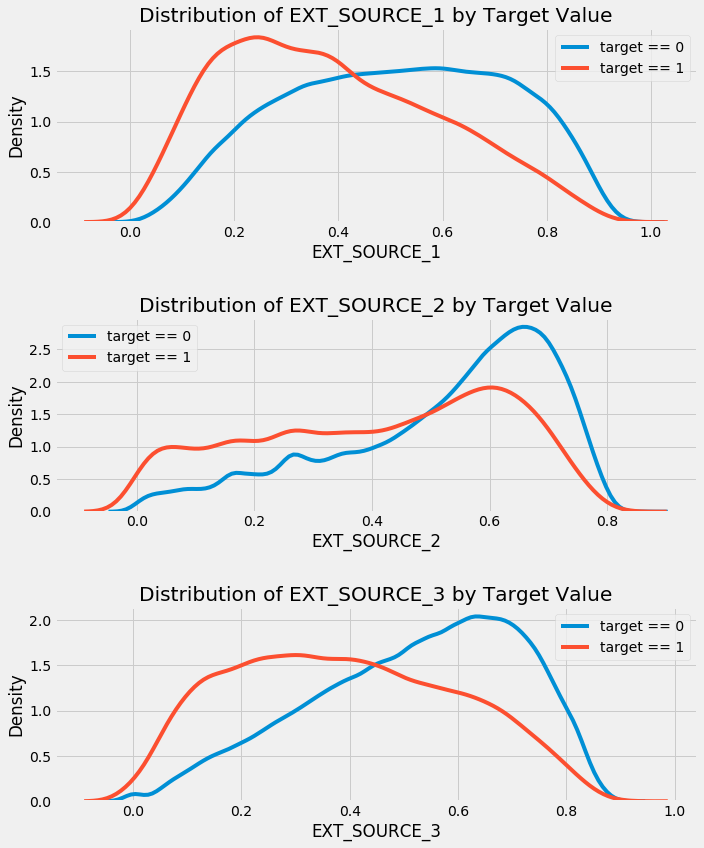

In [64]:
plt.figure(figsize = (10, 12))

# iterate through the sources
for i, source in enumerate(['EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3']):
    
    # create a new subplot for each source
    plt.subplot(3, 1, i + 1)
    # plot repaid loans
    sns.kdeplot(df_train.loc[df_train['TARGET'] == 0, source], label = 'target == 0')
    # plot loans that were not repaid
    sns.kdeplot(df_train.loc[df_train['TARGET'] == 1, source], label = 'target == 1')
    
    # Label the plots
    plt.title('Distribution of %s by Target Value' % source)
    plt.xlabel('%s' % source); plt.ylabel('Density');
    
plt.tight_layout(h_pad = 2.5)

# Feature Engineering

Kaggle competitions are won by feature engineering: those win are those who can create the most useful features out of the data. 

## Polynomial Features

In [65]:
poly_features = df_train[['EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3', 'DAYS_BIRTH', 'TARGET']]
poly_features_test = df_test[['EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3', 'DAYS_BIRTH']]

In [66]:
# imputer for handling missing values


from sklearn.preprocessing import Imputer
imputer = Imputer(strategy = 'median')

poly_target = poly_features['TARGET']
poly_features = poly_features.drop(columns = ['TARGET'])

# Need to impute missing values
poly_features = imputer.fit_transform(poly_features)
poly_features_test = imputer.transform(poly_features_test)

In [67]:
poly_features.shape

(307511, 4)

In [68]:
from sklearn.preprocessing import PolynomialFeatures
                                  
# Create the polynomial object with specified degree
poly_transformer = PolynomialFeatures(degree = 3)

# Train the polynomial features
poly_transformer.fit(poly_features)

# Transform the features
poly_features = poly_transformer.transform(poly_features)
poly_features_test = poly_transformer.transform(poly_features_test)

print('Polynomial Features shape: ', poly_features.shape)

Polynomial Features shape:  (307511, 35)


In [69]:
poly_transformer.get_feature_names(input_features = 
                                   ['EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3', 'DAYS_BIRTH'])[:15]

['1',
 'EXT_SOURCE_1',
 'EXT_SOURCE_2',
 'EXT_SOURCE_3',
 'DAYS_BIRTH',
 'EXT_SOURCE_1^2',
 'EXT_SOURCE_1 EXT_SOURCE_2',
 'EXT_SOURCE_1 EXT_SOURCE_3',
 'EXT_SOURCE_1 DAYS_BIRTH',
 'EXT_SOURCE_2^2',
 'EXT_SOURCE_2 EXT_SOURCE_3',
 'EXT_SOURCE_2 DAYS_BIRTH',
 'EXT_SOURCE_3^2',
 'EXT_SOURCE_3 DAYS_BIRTH',
 'DAYS_BIRTH^2']

In [70]:
df_poly = pd.DataFrame(poly_features, columns = 
             poly_transformer.get_feature_names(['EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3', 'DAYS_BIRTH']))
df_poly.head()

,1,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,DAYS_BIRTH,EXT_SOURCE_1^2,EXT_SOURCE_1 EXT_SOURCE_2,EXT_SOURCE_1 EXT_SOURCE_3,EXT_SOURCE_1 DAYS_BIRTH,EXT_SOURCE_2^2,...,EXT_SOURCE_2^3,EXT_SOURCE_2^2 EXT_SOURCE_3,EXT_SOURCE_2^2 DAYS_BIRTH,EXT_SOURCE_2 EXT_SOURCE_3^2,EXT_SOURCE_2 EXT_SOURCE_3 DAYS_BIRTH,EXT_SOURCE_2 DAYS_BIRTH^2,EXT_SOURCE_3^3,EXT_SOURCE_3^2 DAYS_BIRTH,EXT_SOURCE_3 DAYS_BIRTH^2,DAYS_BIRTH^3
0,1.0,0.083037,0.262949,0.139376,9461.0,0.006895,0.021834,0.011573,785.612748,0.069142,...,0.018181,0.009637,654.152107,0.005108,346.733022,2.353667e+07,0.002707,183.785678,1.247560e+07,8.468590e+11
1,1.0,0.311267,0.622246,0.535276,16765.0,0.096887,0.193685,0.166614,5218.396475,0.387190,...,0.240927,0.207254,6491.237078,0.178286,5583.975307,1.748916e+08,0.153368,4803.518937,1.504475e+08,4.712058e+12
2,1.0,0.505998,0.555912,0.729567,19046.0,0.256034,0.281290,0.369159,9637.236584,0.309038,...,0.171798,0.225464,5885.942404,0.295894,7724.580288,2.016572e+08,0.388325,10137.567875,2.646504e+08,6.908939e+12
3,1.0,0.505998,0.650442,0.535276,19005.0,0.256034,0.329122,0.270849,9616.490669,0.423074,...,0.275185,0.226462,8040.528832,0.186365,6616.894625,2.349331e+08,0.153368,5445.325225,1.933364e+08,6.864416e+12
4,1.0,0.505998,0.322738,0.535276,19932.0,0.256034,0.163305,0.270849,10085.550751,0.104160,...,0.033616,0.055754,2076.117157,0.092471,3443.335521,1.282190e+08,0.153368,5710.929881,2.126570e+08,7.918677e+12


In [71]:
df_poly['TARGET'] = df_train.TARGET

df_poly.corr()['TARGET'].sort_values()

EXT_SOURCE_2 EXT_SOURCE_3                -0.193939
EXT_SOURCE_1 EXT_SOURCE_2 EXT_SOURCE_3   -0.189605
EXT_SOURCE_2 EXT_SOURCE_3 DAYS_BIRTH     -0.181283
EXT_SOURCE_2^2 EXT_SOURCE_3              -0.176428
EXT_SOURCE_2 EXT_SOURCE_3^2              -0.172282
EXT_SOURCE_1 EXT_SOURCE_2                -0.166625
EXT_SOURCE_1 EXT_SOURCE_3                -0.164065
EXT_SOURCE_2                             -0.160295
EXT_SOURCE_2 DAYS_BIRTH                  -0.156873
EXT_SOURCE_1 EXT_SOURCE_2^2              -0.156867
EXT_SOURCE_3                             -0.155892
EXT_SOURCE_1 EXT_SOURCE_2 DAYS_BIRTH     -0.155891
EXT_SOURCE_1 EXT_SOURCE_3 DAYS_BIRTH     -0.151816
EXT_SOURCE_1 EXT_SOURCE_3^2              -0.150822
EXT_SOURCE_3 DAYS_BIRTH                  -0.150109
EXT_SOURCE_2^2                           -0.149512
EXT_SOURCE_2^2 DAYS_BIRTH                -0.149313
EXT_SOURCE_3^2 DAYS_BIRTH                -0.141777
EXT_SOURCE_3^2                           -0.141662
EXT_SOURCE_2^3                 

In [72]:
df_poly = df_poly.drop(['TARGET'],axis=1)

df_poly_test = pd.DataFrame(poly_features_test, columns 
                            = poly_transformer.get_feature_names(['EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3', 'DAYS_BIRTH']))

In [73]:
df_poly['SK_ID_CURR'] = df_train['SK_ID_CURR']
df_train_poly = df_train.merge(df_poly, on = 'SK_ID_CURR', how='left')
df_train_poly.head()

,SK_ID_CURR,NAME_CONTRACT_TYPE,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,REGION_POPULATION_RELATIVE,...,EXT_SOURCE_2^3,EXT_SOURCE_2^2 EXT_SOURCE_3,EXT_SOURCE_2^2 DAYS_BIRTH,EXT_SOURCE_2 EXT_SOURCE_3^2,EXT_SOURCE_2 EXT_SOURCE_3 DAYS_BIRTH,EXT_SOURCE_2 DAYS_BIRTH^2,EXT_SOURCE_3^3,EXT_SOURCE_3^2 DAYS_BIRTH,EXT_SOURCE_3 DAYS_BIRTH^2,DAYS_BIRTH^3
0,100002,0,0,1,0,202500.0,406597.5,24700.5,351000.0,0.018801,...,0.018181,0.009637,654.152107,0.005108,346.733022,2.353667e+07,0.002707,183.785678,1.247560e+07,8.468590e+11
1,100003,0,0,0,0,270000.0,1293502.5,35698.5,1129500.0,0.003541,...,0.240927,0.207254,6491.237078,0.178286,5583.975307,1.748916e+08,0.153368,4803.518937,1.504475e+08,4.712058e+12
2,100004,1,1,1,0,67500.0,135000.0,6750.0,135000.0,0.010032,...,0.171798,0.225464,5885.942404,0.295894,7724.580288,2.016572e+08,0.388325,10137.567875,2.646504e+08,6.908939e+12
3,100006,0,0,1,0,135000.0,312682.5,29686.5,297000.0,0.008019,...,0.275185,0.226462,8040.528832,0.186365,6616.894625,2.349331e+08,0.153368,5445.325225,1.933364e+08,6.864416e+12
4,100007,0,0,1,0,121500.0,513000.0,21865.5,513000.0,0.028663,...,0.033616,0.055754,2076.117157,0.092471,3443.335521,1.282190e+08,0.153368,5710.929881,2.126570e+08,7.918677e+12


In [74]:
df_train_poly.shape

(307511, 275)

In [75]:
df_poly_test['SK_ID_CURR'] = df_test['SK_ID_CURR']
df_test_poly = df_test.merge(df_poly_test, on = 'SK_ID_CURR', how='left')
df_test_poly.head()

,SK_ID_CURR,NAME_CONTRACT_TYPE,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,REGION_POPULATION_RELATIVE,...,EXT_SOURCE_2^3,EXT_SOURCE_2^2 EXT_SOURCE_3,EXT_SOURCE_2^2 DAYS_BIRTH,EXT_SOURCE_2 EXT_SOURCE_3^2,EXT_SOURCE_2 EXT_SOURCE_3 DAYS_BIRTH,EXT_SOURCE_2 DAYS_BIRTH^2,EXT_SOURCE_3^3,EXT_SOURCE_3^2 DAYS_BIRTH,EXT_SOURCE_3 DAYS_BIRTH^2,DAYS_BIRTH^3
0,100001,0,0,1,0,135000.0,568800.0,20560.5,450000.0,0.018850,...,0.492392,0.099469,-11997.802403,0.020094,-2423.698322,2.923427e+08,0.004059,-489.615795,5.905670e+07,-7.123328e+12
1,100005,0,0,1,0,99000.0,222768.0,17370.0,180000.0,0.035792,...,0.024809,0.036829,-1536.577117,0.054673,-2281.043619,9.516956e+07,0.081161,-3386.201665,1.412789e+08,-5.894429e+12
2,100013,0,1,1,0,202500.0,663264.0,69777.0,630000.0,0.019101,...,0.342687,0.299203,-9812.640816,0.261238,-8567.521115,2.809794e+08,0.228089,-7480.393855,2.453261e+08,-8.045687e+12
3,100028,0,0,1,2,315000.0,1575000.0,49018.5,1575000.0,0.026392,...,0.132399,0.159163,-3630.555667,0.191336,-4364.443591,9.955450e+07,0.230013,-5246.681115,1.196786e+08,-2.729912e+12
4,100038,0,1,0,1,180000.0,625500.0,32067.0,625500.0,0.010032,...,0.077139,0.096997,-2362.974127,0.121968,-2971.298294,7.238455e+07,0.153368,-3736.229463,9.101923e+07,-2.217342e+12


In [76]:
df_train_poly, df_test_poly = df_train_poly.align(df_test_poly, join = 'inner', axis = 1)

In [77]:
print(df_train_poly.shape)
print(df_test_poly.shape)

(307511, 274)
(48744, 274)


In [78]:
# No TARGET?

#df_train_poly.TARGET

## Domain Knowledge Features

- CREDIT_INCOME_PERCENT: the percentage of the credit amount relative to a client's income

- ANNUITY_INCOME_PERCENT: the percentage of the loan annuity relative to a client's income

- CREDIT_TERM: the length of the payment in months (since the annuity is the monthly amount due

- DAYS_EMPLOYED_PERCENT: the percentage of the days employed relative to the client's age

In [79]:
df_train_domain = df_train.copy()
df_test_domain = df_test.copy()

df_train_domain['CREDIT_INCOME_PERCENT'] = df_train_domain['AMT_CREDIT'] / df_train_domain['AMT_INCOME_TOTAL']
df_train_domain['ANNUITY_INCOME_PERCENT'] = df_train_domain['AMT_ANNUITY'] / df_train_domain['AMT_INCOME_TOTAL']
df_train_domain['CREDIT_TERM'] = df_train_domain['AMT_ANNUITY'] / df_train_domain['AMT_CREDIT']
df_train_domain['DAYS_EMPLOYED_PERCENT'] = df_train_domain['DAYS_EMPLOYED'] / df_train_domain['DAYS_BIRTH']

In [80]:
df_test_domain['CREDIT_INCOME_PERCENT'] = df_test_domain['AMT_CREDIT'] / df_test_domain['AMT_INCOME_TOTAL']
df_test_domain['ANNUITY_INCOME_PERCENT'] = df_test_domain['AMT_ANNUITY'] / df_test_domain['AMT_INCOME_TOTAL']
df_test_domain['CREDIT_TERM'] = df_test_domain['AMT_ANNUITY'] / df_test_domain['AMT_CREDIT']
df_test_domain['DAYS_EMPLOYED_PERCENT'] = df_test_domain['DAYS_EMPLOYED'] / df_test_domain['DAYS_BIRTH']

# Baseline Model

## Logistic Regression

In [81]:
from sklearn.preprocessing import MinMaxScaler, Imputer

train= df_train.drop(['TARGET'],axis=1).copy()
features = list(train.columns)

In [82]:
test = df_test.copy()

In [83]:
# Median imputation of missing values
imputer = Imputer(strategy = 'median')

# Scale each feature to 0-1
scaler = MinMaxScaler(feature_range = (0, 1))

# Fit on the training data
imputer.fit(train)

# Transform both training and testing data
train = imputer.transform(train)
test = imputer.transform(test)

# Repeat with the scaler
scaler.fit(train)
train = scaler.transform(train)
test = scaler.transform(test)

In [84]:
print('Training data shape: ', train.shape)
print('Testing data shape: ', test.shape)

Training data shape:  (307511, 239)
Testing data shape:  (48744, 239)


In [85]:
from sklearn.linear_model import LogisticRegression

# Make the model with the specified regularization parameter
log_reg = LogisticRegression()

# Train on the training data
log_reg.fit(train, train_labels)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False)

In [86]:
log_reg_pred = log_reg.predict_proba(test)
log_reg_pred

array([[0.94868   , 0.05132   ],
       [0.80467648, 0.19532352],
       [0.96405634, 0.03594366],
       ...,
       [0.95232568, 0.04767432],
       [0.95429427, 0.04570573],
       [0.88025215, 0.11974785]])

In [87]:
#  We want the probability the loan is not repaid, so we will select the second column.

log_reg_pred = log_reg_pred[:,1]

In [88]:
result = df_test[['SK_ID_CURR']]
result['TARGET'] = log_reg_pred

result.head()

,SK_ID_CURR,TARGET
0,100001,0.051320
1,100005,0.195324
2,100013,0.035944
3,100028,0.031453
4,100038,0.111806


In [89]:
result.to_csv('log_reg1.csv',index = False)

In [90]:
# Make C = 0.0001


log_reg = LogisticRegression(C = 0.0001)
log_reg.fit(train, train_labels)

log_reg_pred = log_reg.predict_proba(test)[:,1]

result = df_test[['SK_ID_CURR']]
result['TARGET'] = log_reg_pred

result.head()

,SK_ID_CURR,TARGET
0,100001,0.087932
1,100005,0.164337
2,100013,0.110671
3,100028,0.076574
4,100038,0.155924


In [91]:
result.to_csv('log_reg2.csv',index = False)

In [92]:
# No Valid data? I am creating one. 

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report

train1, valid, label1, label_valid = train_test_split(train, train_labels, test_size=0.20, random_state=20)

In [93]:
log_reg = LogisticRegression(C = 0.0001, class_weight='balanced')
log_reg.fit(train1, label1)

log_reg_pred = log_reg.predict(valid)

print(classification_report(label_valid,log_reg_pred))

              precision    recall  f1-score   support

           0       0.96      0.66      0.78     56539
           1       0.14      0.66      0.24      4964

    accuracy                           0.66     61503
   macro avg       0.55      0.66      0.51     61503
weighted avg       0.89      0.66      0.73     61503



In [94]:
#log_reg = LogisticRegression(class_weight='balanced', penalty='l1')
#log_reg.fit(train1, label1)

#log_reg_pred = log_reg.predict(valid)

#print(classification_report(label_valid,log_reg_pred))

## Random Forest

In [95]:
from sklearn.ensemble import RandomForestClassifier

# Make the random forest classifier
rf = RandomForestClassifier(n_estimators = 100, random_state = 50, verbose = 1, n_jobs = -1)

In [96]:
rf.fit(train1, label1)

rf_pred = rf.predict(valid)
print(classification_report(label_valid, rf_pred))

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   50.8s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  1.6min finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    1.0s


              precision    recall  f1-score   support

           0       0.92      1.00      0.96     56539
           1       1.00      0.00      0.00      4964

    accuracy                           0.92     61503
   macro avg       0.96      0.50      0.48     61503
weighted avg       0.93      0.92      0.88     61503



[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    2.0s finished


In [97]:
rf.fit(train, train_labels)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   42.2s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  1.8min finished


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=-1, oob_score=False, random_state=50, verbose=1,
                       warm_start=False)

In [98]:
predictions = rf.predict_proba(test)[:, 1]

result = df_test[['SK_ID_CURR']]
result['TARGET'] = predictions

# Save the submission dataframe
result.to_csv('rf_baseline.csv', index = False)

[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.8s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    1.5s finished


In [99]:
# Feature Importance

feature_importance_values = rf.feature_importances_
feature_importances = pd.DataFrame({'feature': features, 'importance': feature_importance_values})

In [100]:
feature_importances = feature_importances.sort_values('importance', ascending = False).reset_index()

In [101]:
feature_importances['importance_normalized'] \
    = feature_importances['importance'] / feature_importances['importance'].sum()

In [102]:
feature_importances

,index,feature,importance,importance_normalized
0,32,EXT_SOURCE_2,4.964313e-02,4.964313e-02
1,33,EXT_SOURCE_3,4.698417e-02,4.698417e-02
2,10,DAYS_BIRTH,3.211855e-02,3.211855e-02
3,13,DAYS_ID_PUBLISH,3.211524e-02,3.211524e-02
4,12,DAYS_REGISTRATION,3.156846e-02,3.156846e-02
5,0,SK_ID_CURR,3.028080e-02,3.028080e-02
6,11,DAYS_EMPLOYED,2.981435e-02,2.981435e-02
7,7,AMT_ANNUITY,2.893804e-02,2.893804e-02
8,81,DAYS_LAST_PHONE_CHANGE,2.804977e-02,2.804977e-02
9,6,AMT_CREDIT,2.762858e-02,2.762858e-02


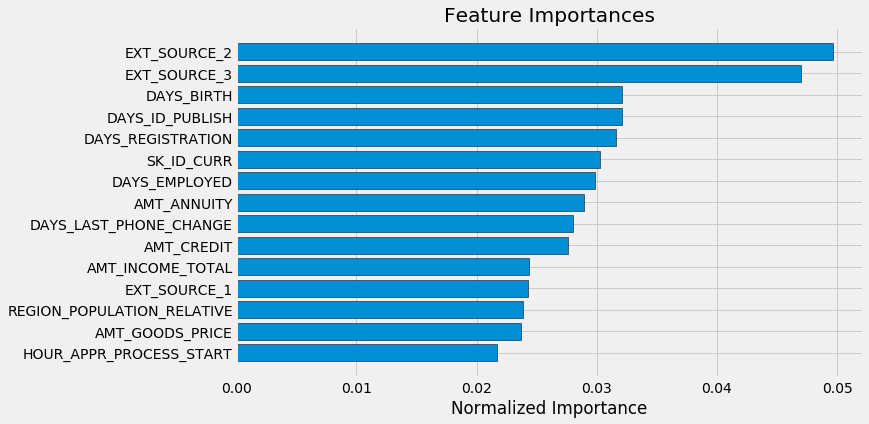

In [103]:
plt.figure(figsize = (10, 6))
ax = plt.subplot()
    
# Need to reverse the index to plot most important on top
ax.barh(list(reversed(list(feature_importances.index[:15]))), 
        feature_importances['importance_normalized'].head(15), 
        align = 'center', edgecolor = 'k')
    
# Set the yticks and labels
ax.set_yticks(list(reversed(list(feature_importances.index[:15]))))
ax.set_yticklabels(feature_importances['feature'].head(15))
    
# Plot labeling
plt.xlabel('Normalized Importance')
plt.title('Feature Importances')
plt.show()

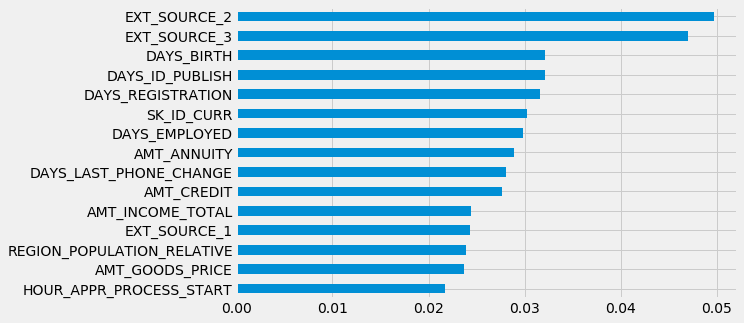

In [104]:
importances = rf.feature_importances_
important_list = {}
for i in np.argsort(importances)[::-1]:
    important_list[features[i]] = importances[i]
    
#print(important_list)

# Visualization
fig, ax = plt.subplots(figsize=(8, 5))
pd.Series(important_list)[::-1][-15:].plot(kind='barh',ax=ax)
plt.show()

## XGBoost

In [105]:
from xgboost.sklearn import XGBClassifier


xgb = XGBClassifier(max_depth=6, learning_rate=0.01, n_estimators=200)

xgb.fit(train1, label1)

xgb_pred = xgb.predict(valid)
print(classification_report(label_valid, xgb_pred))

              precision    recall  f1-score   support

           0       0.92      1.00      0.96     56539
           1       0.45      0.00      0.00      4964

    accuracy                           0.92     61503
   macro avg       0.69      0.50      0.48     61503
weighted avg       0.88      0.92      0.88     61503



In [106]:
xgb.fit(train, train_labels)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.01, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=None, n_estimators=200, n_jobs=1,
              nthread=None, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)

In [108]:
predictions = xgb.predict_proba(test)[:, 1]

result = df_test[['SK_ID_CURR']]
result['TARGET'] = predictions

# Save the submission dataframe
result.to_csv('xgb_baseline.csv', index = False)